# 1. Introduction
In this part, I will be using the data that's been processed in the part 4 as inputs for several machine learning models as an attempt to predict Metacritic scores. <br>
Features to use (all are categorical):
- Platforms
- Genres
- Tags

**For this case, the problem is reframed as a multi-classification problem. There really isn't much difference between a game with a score of 80 and another with a score of 82, etc. How would the results differ if the scores are separated into different tiers instead?**

In [ ]:
# pip install scikit-optimize

In [111]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# import ML libraries
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

# for Bayesian Optimization
import skopt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from skopt import BayesSearchCV


# import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score

# disable all warnings
import warnings
warnings.filterwarnings('ignore')

## 1.1 Load Dataset

In [2]:
df = pd.read_csv('../Data/final_df.csv')
train_set = pd.read_csv('../Data/train_set.csv')
test_set = pd.read_csv('../Data/test_set.csv')

In [3]:
df

,rank,id,name,released,rating,rating_top,ratings_count,reviews_text_count,added,metacritic,...,Indie,Massively Multiplayer,Platformer,Puzzle,RPG,Racing,Shooter,Simulation,Sports,Strategy
0,1,25097,The Legend of Zelda: Ocarina of Time,1998-11-21,4.39,5,486,3,872,99.0,...,0,0,0,0,1,0,0,0,0,0
1,2,54751,Soulcalibur,1998-07-30,4.38,5,47,0,167,98.0,...,0,0,0,0,0,0,0,0,0,0
2,3,3498,Grand Theft Auto V,2013-09-17,4.48,5,3796,21,12383,97.0,...,0,0,0,0,0,0,0,0,0,0
3,4,22511,The Legend of Zelda: Breath of the Wild,2017-03-02,4.56,5,1711,25,3284,97.0,...,0,0,0,0,1,0,0,0,0,0
4,5,27036,Super Mario Galaxy 2,2010-05-23,4.37,5,222,2,420,97.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10739,10740,51427,Tekken (mobile),2017-08-18,2.67,4,4,2,5,NaN,...,0,0,0,0,0,0,0,0,0,0
10740,10741,31876,Bad Dudes,2018-03-21,3.17,3,6,0,5,NaN,...,0,0,0,0,0,0,0,0,0,0
10741,10742,387303,Ray Eager,2019-11-11,4.83,5,5,0,3,NaN,...,0,1,0,0,0,0,0,0,0,0
10742,10743,330541,Stalker Online,2019-10-15,2.83,3,5,0,3,NaN,...,1,1,0,0,1,0,0,0,0,0


See the distribution of the Metacritic scores.

(array([  5.,  14.,  35.,  61., 241., 450., 887., 946., 564.,  96.]),
 array([24. , 31.5, 39. , 46.5, 54. , 61.5, 69. , 76.5, 84. , 91.5, 99. ]),
 <BarContainer object of 10 artists>)

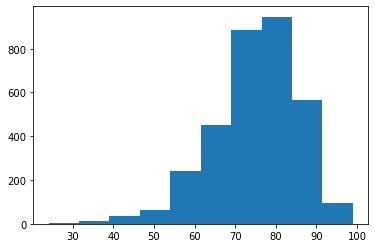

In [4]:
plt.hist(df["metacritic"])

The Metacritic scores do not follow a Normal Distribution.

In [5]:
df["metacritic"].median()

76.0

# 2. Convert to Multi-Classification Problem
I will use the 25th-50th-75th percentile of the Metacritic score as the cut-off for the tier class of the game. <br>

In [6]:
# 25th percentile score
low = df["metacritic"].quantile(.25)
low

69.0

In [7]:
# 50th percentile score
mid = df["metacritic"].quantile(.5)
mid

76.0

In [8]:
# 75th percentile score
high = df["metacritic"].quantile(.75)
high

82.0

Check the distribution of the scores to ensure that the dataset will not be imbalanced after labeling. <br>
First, get the total number of game titles by checking the length of the dataset:

In [9]:
len(df)

10744

I will be splitting the labels as follows: <br>
1. Essential - At least 83
2. Great - Between 77 & 82
3. Good - Between 70 & 76
4. Mediocre - At most 69

Labels are referred from [GameSpot's 10-point review scale](https://www.gamespot.com/review-guidelines/). <br>
Ideally, the dataset is split almost evenly between these four classes:

In [10]:
len(df[df["metacritic"] <= 69.0])

882

In [11]:
len(df[df["metacritic"].between(70, 76)])

811

In [12]:
len(df[df["metacritic"].between(77, 82)])

820

In [13]:
len(df[df["metacritic"] >= 83])

786

In [14]:
mediocre = len(train_set[train_set["metacritic"] <= 69.0])
print("number of mediocre games:" + str(mediocre))
print("mediocre proportion of train set: " + str(mediocre/len(train_set) * 100))
print("*"*5)

good = len(train_set[train_set["metacritic"].between(70, 76)])
print("number of good games:" + str(good))
print("good proportion of train set: " + str(good/len(train_set) * 100))
print("*"*5)

great = len(train_set[train_set["metacritic"].between(77, 82)])
print("number of great games:" + str(great))
print("great proportion of train set: " + str(great/len(train_set) * 100))
print("*"*5)

essential = len(train_set[train_set["metacritic"] >= 83])
print("number of essential games:" + str(essential))
print("essential proportion of train set: " + str(essential/len(train_set) * 100))

number of mediocre games:701
mediocre proportion of train set: 26.522890654559212
*****
number of good games:653
good proportion of train set: 24.706772606886116
*****
number of great games:673
great proportion of train set: 25.46348846008324
*****
number of essential games:616
essential proportion of train set: 23.306848278471435


It seems that the training set already has an almost even split between these four classes (about 25% each).

In [15]:
# manaully input numerical values instead of LabelEncoder()
def create_labels(value):
    # Mediocre
    if value <= 69:
        return 0
    # Good
    elif value <= 76:
        return 1
    # Great
    elif value <= 82:
        return 2
    # Essential
    else:
        return 3

In [16]:
# apply labels

# train set
train_set["labels"] = train_set["metacritic"].apply(lambda row: create_labels(row))

# test set
test_set["labels"] = test_set["metacritic"].apply(lambda row: create_labels(row))

In [17]:
# check if split is roughly equal
train_set["labels"].value_counts()

0    701
2    673
1    653
3    616
Name: labels, dtype: int64

In [18]:
# train set
data = train_set.drop(["metacritic", "labels"], axis=1) # drop labels for training set
data_labels = train_set["labels"] # y variable

# test set
x_test = test_set.drop(["metacritic", "labels"], axis=1) # drop labels for training set
y_test = test_set["labels"] # y variable

# 3. Multi-Class Classification Approach
Since some algorithms are designed for binary (yes/no) classification problems and thus can't be directly used for multi-class classification, these 2 heuristic methods will be used to split a multi-class classification problem into multiple binary classification datasets and train a binary classification model each:
- One-vs-Rest (OvR)
- One-vs-One (OvO)

## 3.1 One-Vs-Rest (OvR) / One-vs-All (OvA)
OvR splits the problem into multiple binary classification problems. <br>
A binary classifier is trained on each binary classification problem and predictions are made from there.

The scikit-learn library provides a separate `OneVsRestClassifier` class that allows the OvR strategy to be used with any classifier. Provide it as an argument to `OneVsRestClassifier`.

### 3.1.1 Dummy Classifier

In [19]:
# set baseline with DummyClassifier
dummy = DummyClassifier()
dummy = OneVsRestClassifier(dummy)
dummy.fit(data, data_labels)

# make predictions
dummy_pred = dummy.predict(x_test)

In [20]:
# assess performance of DummyClassifier
confusion_matrix(y_test, dummy_pred)

array([[ 19,  32,  34,  96],
       [ 15,  22,  29,  92],
       [ 10,  15,  29,  93],
       [ 14,  19,  34, 103]], dtype=int64)

In [22]:
accuracy_score(y_test, dummy_pred)

0.26371951219512196

In [23]:
print(classification_report(y_test, dummy_pred))

              precision    recall  f1-score   support

           0       0.33      0.10      0.16       181
           1       0.25      0.14      0.18       158
           2       0.23      0.20      0.21       147
           3       0.27      0.61      0.37       170

    accuracy                           0.26       656
   macro avg       0.27      0.26      0.23       656
weighted avg       0.27      0.26      0.23       656



### 3.1.2 Logistic Regression

In [24]:
logr = LogisticRegression(multi_class='ovr', max_iter=10000)
logr.fit(data, data_labels)

# make predictions
logr_pred = logr.predict(x_test)

In [25]:
confusion_matrix(y_test, logr_pred)

array([[100,  36,  24,  21],
       [ 53,  44,  36,  25],
       [ 39,  34,  38,  36],
       [ 37,  20,  36,  77]], dtype=int64)

In [26]:
accuracy_score(y_test, logr_pred)

0.3948170731707317

In [27]:
print(classification_report(y_test, logr_pred))

              precision    recall  f1-score   support

           0       0.44      0.55      0.49       181
           1       0.33      0.28      0.30       158
           2       0.28      0.26      0.27       147
           3       0.48      0.45      0.47       170

    accuracy                           0.39       656
   macro avg       0.38      0.39      0.38       656
weighted avg       0.39      0.39      0.39       656



### 3.1.3 Decision Tree Classifier

In [28]:
tree = DecisionTreeClassifier()
tree = OneVsRestClassifier(tree)
tree.fit(data, data_labels)

# make predictions
tree_pred = tree.predict(x_test)

In [29]:
confusion_matrix(y_test, tree_pred)

array([[43, 44, 23, 71],
       [20, 32, 38, 68],
       [13, 22, 37, 75],
       [17, 20, 35, 98]], dtype=int64)

In [30]:
accuracy_score(y_test, tree_pred)

0.3201219512195122

In [31]:
print(classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           0       0.46      0.24      0.31       181
           1       0.27      0.20      0.23       158
           2       0.28      0.25      0.26       147
           3       0.31      0.58      0.41       170

    accuracy                           0.32       656
   macro avg       0.33      0.32      0.30       656
weighted avg       0.34      0.32      0.31       656



### 3.1.4 Random Forest Classifier

In [32]:
forest = RandomForestClassifier()
forest = OneVsRestClassifier(forest)
forest.fit(data, data_labels)

# make predictions
forest_pred = forest.predict(x_test)

In [33]:
confusion_matrix(y_test, forest_pred)

array([[100,  44,  19,  18],
       [ 42,  48,  43,  25],
       [ 31,  39,  46,  31],
       [ 22,  29,  48,  71]], dtype=int64)

In [34]:
accuracy_score(y_test, forest_pred)

0.40396341463414637

In [35]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.51      0.55      0.53       181
           1       0.30      0.30      0.30       158
           2       0.29      0.31      0.30       147
           3       0.49      0.42      0.45       170

    accuracy                           0.40       656
   macro avg       0.40      0.40      0.40       656
weighted avg       0.41      0.40      0.40       656



### 3.1.5 Extra Tree Classifier

In [36]:
extra_tree = ExtraTreesClassifier()
extra_tree = OneVsRestClassifier(extra_tree)
extra_tree.fit(data, data_labels)

# make predictions
extra_tree_pred = extra_tree.predict(x_test)

In [37]:
confusion_matrix(y_test, extra_tree_pred)

array([[95, 45, 21, 20],
       [42, 47, 50, 19],
       [33, 37, 43, 34],
       [21, 26, 47, 76]], dtype=int64)

In [38]:
accuracy_score(y_test, extra_tree_pred)

0.3978658536585366

In [39]:
print(classification_report(y_test, extra_tree_pred))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51       181
           1       0.30      0.30      0.30       158
           2       0.27      0.29      0.28       147
           3       0.51      0.45      0.48       170

    accuracy                           0.40       656
   macro avg       0.39      0.39      0.39       656
weighted avg       0.40      0.40      0.40       656



### 3.1.6 Support Vector Machine

In [40]:
svm = SVC(decision_function_shape='ovr')
# svm = OneVsRestClassifier(svm)
svm.fit(data, data_labels)

# make predictions
svm_pred = svm.predict(x_test)

In [41]:
confusion_matrix(y_test, svm_pred)

array([[109,  35,  22,  15],
       [ 53,  46,  39,  20],
       [ 42,  31,  38,  36],
       [ 35,  18,  45,  72]], dtype=int64)

In [42]:
accuracy_score(y_test, svm_pred)

0.40396341463414637

In [43]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.46      0.60      0.52       181
           1       0.35      0.29      0.32       158
           2       0.26      0.26      0.26       147
           3       0.50      0.42      0.46       170

    accuracy                           0.40       656
   macro avg       0.39      0.39      0.39       656
weighted avg       0.40      0.40      0.40       656



### 3.1.7 K-Nearest Neighbors

In [44]:
knn = KNeighborsClassifier(n_neighbors=3)
knn = OneVsRestClassifier(knn)
knn.fit(data, data_labels)

# make predictions
knn_pred = knn.predict(x_test)

In [45]:
confusion_matrix(y_test, knn_pred)

array([[ 77,  28,  39,  37],
       [ 37,  29,  53,  39],
       [ 36,  25,  35,  51],
       [ 24,  13,  31, 102]], dtype=int64)

In [46]:
accuracy_score(y_test, knn_pred)

0.3704268292682927

In [47]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.44      0.43      0.43       181
           1       0.31      0.18      0.23       158
           2       0.22      0.24      0.23       147
           3       0.45      0.60      0.51       170

    accuracy                           0.37       656
   macro avg       0.35      0.36      0.35       656
weighted avg       0.36      0.37      0.36       656



### 3.1.8 XGBoost

In [48]:
xgb = XGBClassifier()
xgb = OneVsRestClassifier(xgb)
xgb.fit(data, data_labels)

# make predictions
xgb_pred = xgb.predict(x_test)

[21:02:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:02:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [49]:
accuracy_score(y_test, xgb_pred)

0.3978658536585366

In [50]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.46      0.56      0.51       181
           1       0.29      0.28      0.28       158
           2       0.28      0.27      0.27       147
           3       0.52      0.45      0.48       170

    accuracy                           0.40       656
   macro avg       0.39      0.39      0.39       656
weighted avg       0.40      0.40      0.39       656



## 3.2 One-Vs-One (OvO)
OvO splits a multi-class classification dataset into one binary dataset for each class versus every other class.

Number of binary datasets = (NumClasses * (NumClasses – 1)) / 2

Classically, this approach is suggested for support vector machines (SVM) and related kernel-based algorithms. This is believed because the performance of kernel methods does not scale in proportion to the size of the training dataset and using subsets of the training data may counter this effect.

### 3.2.1 Dummy Classifier

In [52]:
# set baseline with DummyClassifier
dummy = DummyClassifier()
dummy = OneVsOneClassifier(dummy)
dummy.fit(data, data_labels)

# make predictions
dummy_pred = dummy.predict(x_test)

In [53]:
# assess performance of DummyClassifier
confusion_matrix(y_test, dummy_pred)

array([[32, 38, 59, 52],
       [21, 26, 58, 53],
       [21, 35, 37, 54],
       [31, 31, 47, 61]], dtype=int64)

In [54]:
accuracy_score(y_test, dummy_pred)

0.23780487804878048

In [55]:
print(classification_report(y_test, dummy_pred))

              precision    recall  f1-score   support

           0       0.30      0.18      0.22       181
           1       0.20      0.16      0.18       158
           2       0.18      0.25      0.21       147
           3       0.28      0.36      0.31       170

    accuracy                           0.24       656
   macro avg       0.24      0.24      0.23       656
weighted avg       0.25      0.24      0.23       656



### 3.2.2 Logistic Regression

In [56]:
logr = LogisticRegression(max_iter=10000)
logr = OneVsOneClassifier(logr)
logr.fit(data, data_labels)

# make predictions
logr_pred = logr.predict(x_test)

In [57]:
confusion_matrix(y_test, logr_pred)

array([[98, 38, 27, 18],
       [49, 44, 37, 28],
       [40, 33, 37, 37],
       [37, 18, 34, 81]], dtype=int64)

In [58]:
accuracy_score(y_test, logr_pred)

0.39634146341463417

In [59]:
print(classification_report(y_test, logr_pred))

              precision    recall  f1-score   support

           0       0.44      0.54      0.48       181
           1       0.33      0.28      0.30       158
           2       0.27      0.25      0.26       147
           3       0.49      0.48      0.49       170

    accuracy                           0.40       656
   macro avg       0.38      0.39      0.38       656
weighted avg       0.39      0.40      0.39       656



### 3.2.3 Decision Forest Classifier

In [60]:
tree = DecisionTreeClassifier()
tree = OneVsOneClassifier(tree)
tree.fit(data, data_labels)

# make predictions
tree_pred = tree.predict(x_test)

In [61]:
confusion_matrix(y_test, tree_pred)

array([[67, 56, 32, 26],
       [35, 38, 53, 32],
       [25, 23, 53, 46],
       [22, 19, 56, 73]], dtype=int64)

In [62]:
accuracy_score(y_test, tree_pred)

0.3521341463414634

In [63]:
print(classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           0       0.45      0.37      0.41       181
           1       0.28      0.24      0.26       158
           2       0.27      0.36      0.31       147
           3       0.41      0.43      0.42       170

    accuracy                           0.35       656
   macro avg       0.35      0.35      0.35       656
weighted avg       0.36      0.35      0.35       656



### 3.2.4 Random Forest Classifier

In [64]:
forest = RandomForestClassifier()
forest = OneVsOneClassifier(forest)
forest.fit(data, data_labels)

# make predictions
forest_pred = forest.predict(x_test)

In [65]:
confusion_matrix(y_test, forest_pred)

array([[94, 42, 27, 18],
       [40, 49, 53, 16],
       [27, 36, 50, 34],
       [19, 25, 55, 71]], dtype=int64)

In [66]:
accuracy_score(y_test, forest_pred)

0.4024390243902439

In [67]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.52      0.52      0.52       181
           1       0.32      0.31      0.32       158
           2       0.27      0.34      0.30       147
           3       0.51      0.42      0.46       170

    accuracy                           0.40       656
   macro avg       0.41      0.40      0.40       656
weighted avg       0.41      0.40      0.41       656



### 3.2.5 Extra Tree Classifier

In [68]:
extra_tree = ExtraTreesClassifier()
extra_tree = OneVsOneClassifier(extra_tree)
extra_tree.fit(data, data_labels)

# make predictions
extra_tree_pred = extra_tree.predict(x_test)

In [69]:
confusion_matrix(y_test, extra_tree_pred)

array([[95, 49, 21, 16],
       [39, 53, 45, 21],
       [30, 38, 52, 27],
       [25, 27, 55, 63]], dtype=int64)

In [70]:
accuracy_score(y_test, extra_tree_pred)

0.4009146341463415

In [71]:
print(classification_report(y_test, extra_tree_pred))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51       181
           1       0.32      0.34      0.33       158
           2       0.30      0.35      0.33       147
           3       0.50      0.37      0.42       170

    accuracy                           0.40       656
   macro avg       0.40      0.40      0.40       656
weighted avg       0.41      0.40      0.40       656



### 3.2.6 Support Vector Machine

In [72]:
svm = SVC(decision_function_shape='ovo')
svm.fit(data, data_labels)

# make predictions
svm_pred = svm.predict(x_test)

In [73]:
confusion_matrix(y_test, svm_pred)

array([[109,  35,  22,  15],
       [ 53,  46,  39,  20],
       [ 42,  31,  38,  36],
       [ 35,  18,  45,  72]], dtype=int64)

In [74]:
accuracy_score(y_test, svm_pred)

0.40396341463414637

In [75]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.46      0.60      0.52       181
           1       0.35      0.29      0.32       158
           2       0.26      0.26      0.26       147
           3       0.50      0.42      0.46       170

    accuracy                           0.40       656
   macro avg       0.39      0.39      0.39       656
weighted avg       0.40      0.40      0.40       656



### 3.2.7 K-Nearest Neighbors

In [76]:
knn = KNeighborsClassifier(n_neighbors=3)
knn = OneVsOneClassifier(knn)
knn.fit(data, data_labels)

# make predictions
knn_pred = knn.predict(x_test)

In [77]:
confusion_matrix(y_test, knn_pred)

array([[91, 46, 23, 21],
       [53, 44, 42, 19],
       [49, 39, 28, 31],
       [40, 21, 38, 71]], dtype=int64)

In [78]:
accuracy_score(y_test, knn_pred)

0.3567073170731707

In [79]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.39      0.50      0.44       181
           1       0.29      0.28      0.29       158
           2       0.21      0.19      0.20       147
           3       0.50      0.42      0.46       170

    accuracy                           0.36       656
   macro avg       0.35      0.35      0.35       656
weighted avg       0.36      0.36      0.35       656



### 3.2.8 XGBoost

In [80]:
xgb = XGBClassifier()
xgb = OneVsOneClassifier(xgb)
xgb.fit(data, data_labels)

# make predictions
xgb_pred = xgb.predict(x_test)

[21:09:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:09:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:09:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:09:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [81]:
confusion_matrix(y_test, xgb_pred)

array([[91, 35, 34, 21],
       [42, 43, 49, 24],
       [25, 36, 42, 44],
       [22, 19, 47, 82]], dtype=int64)

In [82]:
accuracy_score(y_test, xgb_pred)

0.3932926829268293

In [83]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.51      0.50      0.50       181
           1       0.32      0.27      0.30       158
           2       0.24      0.29      0.26       147
           3       0.48      0.48      0.48       170

    accuracy                           0.39       656
   macro avg       0.39      0.39      0.39       656
weighted avg       0.40      0.39      0.39       656



Summary of results:

| Model                        |  F1 Score (OvR)  |  F1 Score (OvO)  |
| ---------------------------- |:----------------:|:----------------:|
| Dummy Classifier             | 0.26             | 0.24             |
| Logistic Regression          | 0.39             | 0.40             |
| Decision Tree Classifier     | 0.32             | 0.35             |
| **Random Forest Classifier**     | **0.40**             | **0.40**             |
| **Extra Tree Classifier**        | **0.40**             | **0.40**             |
| **Support Vector Machine**       | **0.40**             | **0.40**             |
| K-Nearest Neighbors          | 0.37             | 0.36             |
| XGBoost Classifier           | 0.40             | 0.39             |

It seems that there is virtually no difference in using either OvR or OvO. <br>
Random Forest Classifier, Extra Tree Classifier and Support Vector Machine have the best result.

# 4. Optimisation - Model Tuning
## 4.1 BayesSearchCV
Since the Regression Approach already used the `RandomizedSearchCV` and `GridSearchCV` methods for optimisation, I will try the more efficient Bayesian Optimization via the `BayesSearchCV` class.

In [92]:
# define search space
params = dict()
params['n_estimators'] = [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]
params['max_features'] = ['auto', 'sqrt']
params['max_depth'] = [int(x) for x in np.linspace(10, 100, num = 11)]
params['min_samples_split'] = [2, 5, 10]
params['min_samples_leaf'] = [1, 2, 4]
params['bootstrap'] = [True, False]

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define the search
search = BayesSearchCV(estimator=RandomForestClassifier(), search_spaces=params, n_jobs=-1, cv=cv)

In [93]:
# perform the search
search.fit(data, data_labels)

# report the best result
print(search.best_score_)
print(search.best_params_)

0.3927315608919383
OrderedDict([('bootstrap', False), ('max_depth', 73), ('max_features', 'auto'), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 100)])


In [94]:
# create best Random Forest Classifier
best_random = search.best_estimator_

# make predictions
search_pred = best_random.predict(x_test)

confusion_matrix(y_test, search_pred)

array([[108,  39,  12,  22],
       [ 46,  41,  44,  27],
       [ 28,  39,  43,  37],
       [ 26,  25,  41,  78]], dtype=int64)

In [95]:
accuracy_score(y_test, search_pred)

0.4115853658536585

In [96]:
print(classification_report(y_test, search_pred))

              precision    recall  f1-score   support

           0       0.52      0.60      0.56       181
           1       0.28      0.26      0.27       158
           2       0.31      0.29      0.30       147
           3       0.48      0.46      0.47       170

    accuracy                           0.41       656
   macro avg       0.40      0.40      0.40       656
weighted avg       0.40      0.41      0.41       656



## 4.2 Create Predicted Output CSV

In [99]:
# re-create test_set to retrieve back the name list
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
test_set.drop([
'rank',
'id',
'released',
'rating',
'rating_top',
'ratings_count',
'reviews_text_count',
'added',
'playtime',
'suggestions_count',
'reviews_count',
'parent_platforms',
'platforms',
'ratings',
'genres',
'tags',
'Year'], axis = 1, inplace=True) 
test_set.dropna(inplace=True)

# Create new df
final_data = pd.DataFrame({'Game Title':test_set['name'], 'Predicted Tier':search_pred}).set_index('Game Title')

# combine with main df based on common game name
merged = pd.merge(final_data, df, left_on='Game Title', right_on='name', how='left')

In [100]:
# manaully inverse the encoded labels to text
def inverse_labels(value):
    # Mediocre
    if value == 0:
        return "Mediocre"
    # Good
    elif value == 1:
        return "Good"
    # Great
    elif value == 2:
        return "Great"
    # Essential
    else:
        return "Essential"

In [107]:
# create final df
results = merged.copy()

# add score tier to final result df
results["tier"] = results["metacritic"].apply(lambda row: create_labels(row))
results["tier"] = results["tier"].apply(lambda row: inverse_labels(row))
# revert numerical predicted tiers to text
results["Predicted Tier"] = results["Predicted Tier"].apply(lambda row: inverse_labels(row))

In [108]:
# keep only these columns
results = results[['name', 'tier', 'Predicted Tier']]
display(results)

,name,tier,Predicted Tier
0,Resident Evil Outbreak: File 2,Mediocre,Essential
1,MASSIVE CHALICE,Good,Good
2,Fahrenheit (Indigo Prophecy),Essential,Mediocre
3,Dragon Age: Origins - Ultimate Edition,Essential,Mediocre
4,Stories: The Path of Destinies,Good,Great
...,...,...,...
651,Left 4 Dead 2,Essential,Mediocre
652,Ice Age 3 Dawn of the Dinosaurs,Mediocre,Mediocre
653,SOMA,Essential,Good
654,Danger Zone,Mediocre,Mediocre


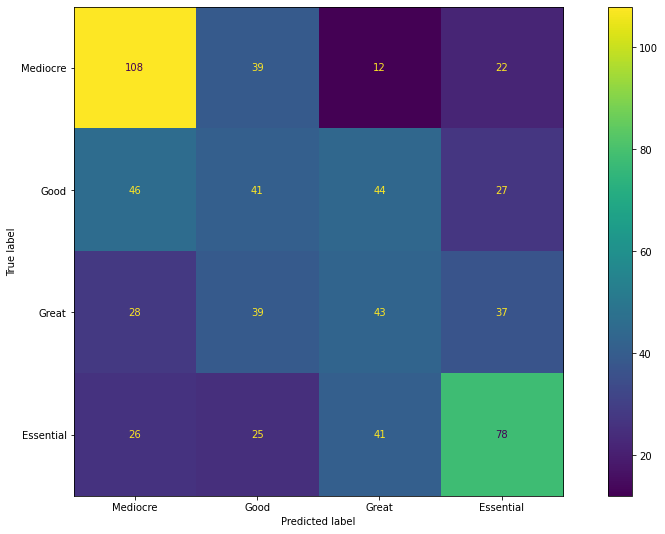

In [112]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(16, 9))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, search_pred),
    display_labels=["Mediocre", "Good", "Great", "Essential"],
)

cmp.plot(ax=ax)
plt.show()

In [114]:
y_pred_probs = best_random.predict_proba(x_test)

# calculate ROC_AUC
roc_auc_score(
    y_test, y_pred_probs, multi_class="ovr", average="weighted"
  )

0.6860707915968198

In [116]:
results.to_csv('../Predicted Scores/results_classification_rf_grid.csv', index=False)

# 5. Feature Importance
Which factors helps in distinguishing the score tiers?

In [115]:
forest_feature = pd.DataFrame({"feature": data.columns,
                            "importance": best_random.feature_importances_})

# factors that tend to give higher Stars (top) and lower Stars (bottom)
forest_feature.sort_values("importance", ascending = False)

,feature,importance
12,PC,0.026402
1,Nintendo,0.020593
265,Trading,0.019103
433,Indie,0.016651
35,Great Soundtrack,0.016486
...,...,...
366,Chess,0.000000
365,Werewolves,0.000000
364,360 Video,0.000000
287,Agriculture,0.000000


It appears that releasing a game on PC or a Nintendo device could affect its Metacritic Score. <br>
In terms of game design, a game that feature promiment trading elements and a great sountrack could potentially distinguish itself from the rest. <br>
An indie games are rated differently from AAA games as well.

# 6. Conclusion
From the confusion matrix, it seems that all the models are not very accurate in predicting a game's score tier.

Maybe instead of using 25-50-75 quartile, it would be better to split the scores into wider bins `(<50, 51 - 60, 61 - 70, 71 - 80, 81 - 90, >90)`. Since the 25-50-75 quartile cut-off scores are very close to one another `(69, 76, 82)`, it would be difficult for the models to distinguish each tier clearly. This may be why the models aren't good at picking out the "Good" and "Great" games as well as the "Mediocre" and "Essential" ones.

Summary of results:

| Model                        |  F1 Score (OvR)  |  F1 Score (OvO)  |
| ---------------------------- |:----------------:|:----------------:|
| Random Forest Classifier     | 0.40             | 0.40             |
| Extra Tree Classifier        | 0.40             | 0.40             |
| Support Vector Machine       | 0.40             | 0.40             |
| **Random Forest Classifier (optimised)**    | **0.41**             | -             |